# Final Project - Basics of Deep Learning
---
<br>

### Name and ID:
Student 1: Tov Hakimi - 207845579
<br>
Student 2: Shani Lev - 211632831

**For the 'Explainer.md' file - which will help you understand how to run to notebook properly, run this command:**

In [ ]:
import gdown
!gdown --id 1_uL5nf61qskEObnDxGFw8drJIQCLLG3x

## Import Libraries

In [ ]:
%%capture
import kagglehub
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import torch.nn.functional as F

!pip install ipython-autotime
%load_ext autotime

time: 390 µs (started: 2025-03-11 12:59:57 +00:00)


#Import best model weigth & cropped images folders from Google Drive

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving stanford_cars_with_class_names.xlsx to stanford_cars_with_class_names (1).xlsx
time: 4.58 s (started: 2025-03-11 13:00:03 +00:00)


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.12 s (started: 2025-03-11 13:00:09 +00:00)


In [ ]:
%%capture
!unzip -o "/content/drive/MyDrive/cropped_images.zip" -d "/content/"

time: 5.23 s (started: 2025-03-11 13:00:12 +00:00)


In [ ]:
excel_path = "stanford_cars_with_class_names.xlsx"

df_train = pd.read_excel(excel_path, sheet_name="train")
df_test = pd.read_excel(excel_path, sheet_name="test")

train_images_path = "/content/content/dataset/cropped_train"
test_images_path = "/content/content/dataset/cropped_test"

def add_image_paths(data, images_path):
    data['image_path'] = data['image'].apply(lambda img: os.path.join(images_path, img.strip("'")))
    return data

train_data = add_image_paths(df_train, train_images_path)
test_data = add_image_paths(df_test, test_images_path)

time: 1.69 s (started: 2025-03-11 13:00:22 +00:00)


## Best Model Architecture

In [ ]:
class Experiment2(nn.Module):
    def __init__(self, num_classes=196, freeze_until=3):
        super(Experiment2, self).__init__()

        self.base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

        for idx, param in enumerate(self.base_model.features.parameters()):
            if idx < freeze_until:
                param.requires_grad = False

        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features, num_classes)
        )

        self.base_model.num_classes = num_classes

    def forward(self, x):
        return self.base_model(x)

time: 799 µs (started: 2025-03-11 13:00:25 +00:00)


In [ ]:
%%capture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = Experiment2(num_classes=196).to(device)
best_model.load_state_dict(torch.load('/content/drive/MyDrive/experiment_2_weights.pth', map_location=device))
best_model.eval()

time: 355 ms (started: 2025-03-11 13:00:27 +00:00)


#Extract embeddings from each image

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def extract_embedding(model, image_path, device):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model.base_model.features(image)
        pooled = F.adaptive_avg_pool2d(features, (1, 1))
        embedding = pooled.view(pooled.size(0), -1)
    return embedding.cpu().numpy().flatten()

time: 1.07 ms (started: 2025-03-11 13:00:29 +00:00)


In [ ]:
image_embeddings = {}

for idx, row in train_data.iterrows():
    image_path = row['image_path']
    embedding = extract_embedding(best_model, image_path, device)
    image_embeddings[image_path] = embedding

image_paths = list(image_embeddings.keys())
embeddings_matrix = np.array(list(image_embeddings.values()))

time: 1min 23s (started: 2025-03-11 13:00:29 +00:00)


#Experiment 1

 Initializes and fits a KNN (k = 5) model using cosine similarity for image retrieval.

In [ ]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=10, metric="cosine")
knn.fit(embeddings_matrix)

NearestNeighbors(metric='cosine', n_neighbors=10)

time: 60.6 ms (started: 2025-03-11 13:01:57 +00:00)


## Retrieving Similar Images

Extracts the embedding of a query image and finds the most similar images using the KNN model.

In [ ]:
def find_similar_images(query_image_path, model, device):
    query_embedding = extract_embedding(model, query_image_path, device)

    if query_embedding is None or len(query_embedding) == 0:
        print(f"Warning: No embedding found for {query_image_path}")
        return []

    distances, indices = knn.kneighbors([query_embedding])

    similar_images = [image_paths[idx] for idx in indices[0]]

    return similar_images

time: 556 µs (started: 2025-03-11 13:01:57 +00:00)


# Visualizing Image Retrieval Results

Displays multiple query images alongside their top-K most similar images retrieved using the KNN model.

In [ ]:
def show_multiple_queries_with_neighbors(sample_test_images, k=5):
    num_queries = len(sample_test_images)

    fig, axes = plt.subplots(num_queries, k + 1, figsize=(15, 3 * num_queries))

    if num_queries == 1:
        axes = [axes]

    for i, (idx, row) in enumerate(sample_test_images.iterrows()):
        query_image_path = row['image_path']
        similar_images = find_similar_images(query_image_path, best_model, device)

        axes[i][0].imshow(Image.open(query_image_path))
        axes[i][0].set_title("Query", fontsize=10)
        axes[i][0].axis("off")

        for j in range(k):
            if j < len(similar_images):
                img_path = similar_images[j]
                axes[i][j + 1].imshow(Image.open(img_path))
                file_name = os.path.basename(img_path)
                axes[i][j + 1].set_title(file_name, fontsize=8)
                axes[i][j + 1].axis("off")

    plt.tight_layout()
    plt.show()

sample_test_images = test_data.sample(10, random_state=np.random.randint(0, 1000))
show_multiple_queries_with_neighbors(sample_test_images, k=5)

Output hidden; open in https://colab.research.google.com to view.

# Precision and Recall Calculation

Computes Precision@K and Recall@K to evaluate the retrieval performance by checking how many of the retrieved images belong to the correct class.

In [ ]:
def calculate_precision_and_recall_at_k(similar_images, ground_truth_class, K=5):
    if not similar_images:
        return 0.0, 0.0

    K = min(K, len(similar_images))
    correct = 0
    retrieved = 0

    total_relevant = (train_data['class'] == ground_truth_class).sum()

    for idx in range(K):
        predicted_image_path = similar_images[idx]

        match = train_data[train_data['image_path'] == predicted_image_path]['class']
        if match.empty:
            continue

        predicted_class = match.values[0]

        if predicted_class == ground_truth_class:
            correct += 1

        retrieved += 1

    precision_at_k = correct / K if K > 0 else 0
    recall_at_k = correct / total_relevant if total_relevant > 0 else 0

    return precision_at_k, recall_at_k

time: 755 µs (started: 2025-03-11 13:02:03 +00:00)


#Mean Precision and Recall Evaluation

Computes the average Precision@K and Recall@K across multiple query images to assess overall retrieval effectiveness.

In [ ]:
def calculate_precision_and_recall_for_sample(sample_test_images, k=5):
    total_precision = 0
    total_recall = 0
    num_images = len(sample_test_images)

    for _, row in sample_test_images.iterrows():
        query_image_path = row['image_path']
        ground_truth_class = row['class']

        similar_images = find_similar_images(query_image_path, best_model, device)

        precision_at_k, recall_at_k = calculate_precision_and_recall_at_k(similar_images, ground_truth_class, k)

        total_precision += precision_at_k
        total_recall += recall_at_k

    mean_precision = total_precision / num_images
    mean_recall = total_recall / num_images

    return mean_precision, mean_recall

mean_precision, mean_recall = calculate_precision_and_recall_for_sample(sample_test_images, k=5)

print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")

Mean Precision: 0.7600
Mean Recall: 0.0916
time: 1.24 s (started: 2025-03-11 13:02:03 +00:00)


#Precision-Recall Plot

Visualizes Precision@K and Recall@K for multiple query images, highlighting retrieval performance across different test samples.

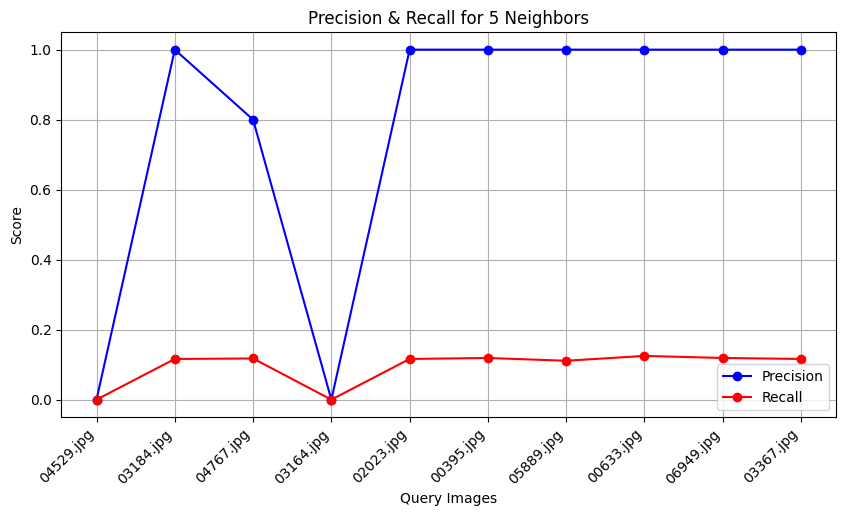

time: 1.25 s (started: 2025-03-11 13:02:04 +00:00)


In [ ]:
def plot_precision_recall_for_sample(sample_test_images, k=5):
    precisions = []
    recalls = []
    image_names = []

    for _, row in sample_test_images.iterrows():
        query_image_path = row['image_path']
        ground_truth_class = row['class']

        similar_images = find_similar_images(query_image_path, best_model, device)

        precision_at_k, recall_at_k = calculate_precision_and_recall_at_k(similar_images, ground_truth_class, k)

        precisions.append(precision_at_k)
        recalls.append(recall_at_k)
        image_names.append(os.path.basename(query_image_path))

    plt.figure(figsize=(10, 5))
    plt.plot(image_names, precisions, marker='o', linestyle='-', color='blue', label='Precision')
    plt.plot(image_names, recalls, marker='o', linestyle='-', color='red', label='Recall')
    plt.xlabel("Query Images")
    plt.ylabel("Score")
    plt.title(f"Precision & Recall for {k} Neighbors")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.grid()
    plt.show()

plot_precision_recall_for_sample(sample_test_images, k=5)

#Experiment 2

Uses the Euclidean distance metric to find the 10 nearest neighbors, providing an alternative similarity measure for image retrieval.

In [ ]:
knn = NearestNeighbors(n_neighbors=10, metric="euclidean")
knn.fit(embeddings_matrix)

NearestNeighbors(metric='euclidean', n_neighbors=10)

time: 8.27 ms (started: 2025-03-11 13:02:07 +00:00)


#Finding Similar Images Using Euclidean Distance

Retrieves the most similar images by computing the Euclidean distance between feature embeddings, providing an alternative retrieval method to cosine similarity.

In [ ]:
def find_similar_images_euclidean(query_image_path, model, device):
    query_embedding = extract_embedding(model, query_image_path, device)

    if query_embedding is None or len(query_embedding) == 0:
        print(f"Warning: No embedding found for {query_image_path}")
        return []

    distances, indices = knn_euclidean.kneighbors([query_embedding])

    similar_images = [image_paths[idx] for idx in indices[0]]

    return similar_images

time: 582 µs (started: 2025-03-11 13:02:07 +00:00)


#Selecting Random Test Images

Randomly samples 10 images from the test dataset for evaluating image retrieval using Euclidean distance.

In [ ]:
sample_test_images_euclidean = test_data.sample(10, random_state=np.random.randint(0, 1000))

time: 1.23 ms (started: 2025-03-11 13:02:07 +00:00)


#Displaying Query Images with Euclidean Neighbors

Visualizes the selected test images alongside their top 10 most similar images retrieved using Euclidean distance.

In [ ]:
show_multiple_queries_with_neighbors(sample_test_images_euclidean, k=10)

Output hidden; open in https://colab.research.google.com to view.

#Precision and Recall Calculation for Euclidean Distance

Computes the mean precision and recall for the top 10 nearest neighbors using Euclidean distance, evaluating how well the retrieval system performs.

In [ ]:
mean_precision_euclidean, mean_recall_euclidean = calculate_precision_and_recall_for_sample(sample_test_images_euclidean, k=10)
print(f"Mean Precision@10 (Euclidean): {mean_precision_euclidean:.4f}")
print(f"Mean Recall@10 (Euclidean): {mean_recall_euclidean:.4f}")

Mean Precision@10 (Euclidean): 0.7800
Mean Recall@10 (Euclidean): 0.1973
time: 1.02 s (started: 2025-03-11 13:02:14 +00:00)


#Precision and Recall Visualization for Euclidean Distance

Plots precision and recall scores for each query image, demonstrating retrieval performance using Euclidean distance with K=10 neighbors.

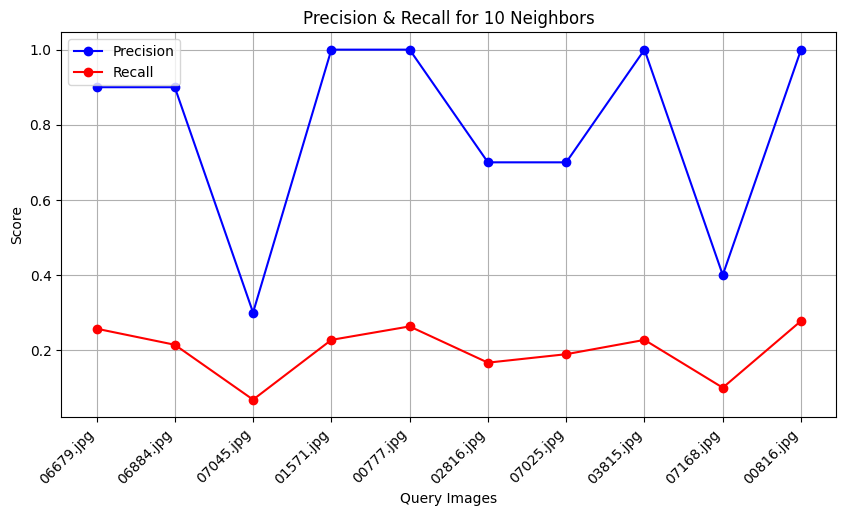

time: 1.2 s (started: 2025-03-11 13:02:15 +00:00)


In [ ]:
plot_precision_recall_for_sample(sample_test_images_euclidean, k=10)

#Experiment 3

Initializes two Nearest Neighbors models using Cosine and Manhattan distance metrics, each with K=5, to compare different similarity measures and later combine them for a weighted retrieval approach.

In [ ]:
from sklearn.neighbors import NearestNeighbors

knn_cosine = NearestNeighbors(n_neighbors=5, metric="cosine")
knn_cosine.fit(embeddings_matrix)

knn_manhattan = NearestNeighbors(n_neighbors=5, metric="manhattan")
knn_manhattan.fit(embeddings_matrix)

NearestNeighbors(metric='manhattan')

time: 12.3 ms (started: 2025-03-11 13:02:17 +00:00)


#Weighted Distance-Based Image Retrieval

Computes similarity scores using a weighted combination of Cosine (70%) and Manhattan (30%) distances. This approach balances global feature alignment (Cosine) with absolute feature differences (Manhattan), improving retrieval robustness. The top K=5 closest images are returned based on the combined similarity score.

In [ ]:
def find_weighted_similar_images(query_image_path, model, device, w_cosine=0.7, w_manhattan=0.3, k=5):
    query_embedding = extract_embedding(model, query_image_path, device)

    distances_cosine, indices_cosine = knn_cosine.kneighbors([query_embedding])
    distances_manhattan, indices_manhattan = knn_manhattan.kneighbors([query_embedding])

    combined_scores = {}

    for i in range(len(indices_cosine[0])):
        img_path = image_paths[indices_cosine[0][i]]
        combined_scores[img_path] = w_cosine * distances_cosine[0][i]

    for i in range(len(indices_manhattan[0])):
        img_path = image_paths[indices_manhattan[0][i]]
        if img_path in combined_scores:
            combined_scores[img_path] += w_manhattan * distances_manhattan[0][i]
        else:
            combined_scores[img_path] = w_manhattan * distances_manhattan[0][i]

    sorted_images = sorted(combined_scores.items(), key=lambda x: x[1])
    return [img[0] for img in sorted_images[:k]]

time: 841 µs (started: 2025-03-11 13:02:17 +00:00)


#Visualizing Image Retrieval with Weighted Distance

This function displays the top-K nearest images retrieved using a weighted distance approach combining Cosine (70%) and Manhattan (30%) metrics. Each row represents a query image followed by its 5 most similar images, providing a clear visual assessment of retrieval performance.

In [ ]:
def show_multiple_queries_with_weighted_neighbors(sample_test_images, k=5):
    num_queries = len(sample_test_images)

    fig, axes = plt.subplots(num_queries, k + 1, figsize=(15, 3 * num_queries))

    if num_queries == 1:
        axes = [axes]

    for i, (idx, row) in enumerate(sample_test_images.iterrows()):
        query_image_path = row['image_path']
        similar_images = find_weighted_similar_images(query_image_path, best_model, device, w_cosine=0.7, w_manhattan=0.3, k=k)

        axes[i][0].imshow(Image.open(query_image_path))
        axes[i][0].set_title("Query", fontsize=10)
        axes[i][0].axis("off")

        for j in range(k):
            if j < len(similar_images):
                img_path = similar_images[j]
                axes[i][j + 1].imshow(Image.open(img_path))
                file_name = os.path.basename(img_path)
                axes[i][j + 1].set_title(file_name, fontsize=8)
                axes[i][j + 1].axis("off")

    plt.tight_layout()
    plt.show()

sample_test_images = test_data.sample(10, random_state=np.random.randint(0, 1000))
show_multiple_queries_with_weighted_neighbors(sample_test_images, k=5)

Output hidden; open in https://colab.research.google.com to view.

#Evaluating Precision and Recall for Weighted Distance

This function computes the mean Precision@K and Recall@K for weighted distance-based image retrieval. By integrating Cosine (70%) and Manhattan (30%) distances, the function assesses retrieval effectiveness across multiple queries and provides a summary of overall performance.

In [ ]:
def calculate_precision_and_recall_for_weighted(sample_test_images, k=5):
    total_precision = 0
    total_recall = 0
    num_images = len(sample_test_images)

    for _, row in sample_test_images.iterrows():
        query_image_path = row['image_path']
        ground_truth_class = row['class']

        similar_images = find_weighted_similar_images(query_image_path, best_model, device, w_cosine=0.7, w_manhattan=0.3, k=k)

        precision_at_k, recall_at_k = calculate_precision_and_recall_at_k(similar_images, ground_truth_class, k)

        total_precision += precision_at_k
        total_recall += recall_at_k

    mean_precision = total_precision / num_images
    mean_recall = total_recall / num_images

    return mean_precision, mean_recall

mean_precision_weighted, mean_recall_weighted = calculate_precision_and_recall_for_weighted(sample_test_images, k=5)

print(f"Mean Precision (Weighted Distance): {mean_precision_weighted:.4f}")
print(f"Mean Recall (Weighted Distance): {mean_recall_weighted:.4f}")

Mean Precision (Weighted Distance): 0.8400
Mean Recall (Weighted Distance): 0.1025
time: 1.54 s (started: 2025-03-11 13:02:23 +00:00)


#Precision-Recall Plot for Weighted Distance

This function visualizes the Precision@K and Recall@K for weighted distance-based image retrieval. It plots precision and recall values for each queried image, offering insights into retrieval accuracy when combining Cosine (70%) and Manhattan (30%) distances.

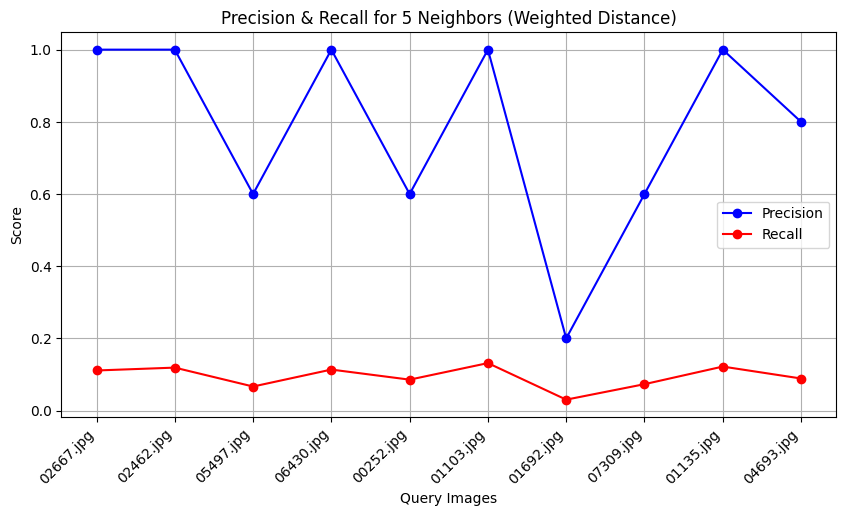

time: 1.28 s (started: 2025-03-11 13:02:24 +00:00)


In [ ]:
def plot_precision_recall_for_weighted(sample_test_images, k=5):
    precisions = []
    recalls = []
    image_names = []

    for _, row in sample_test_images.iterrows():
        query_image_path = row['image_path']
        ground_truth_class = row['class']

        similar_images = find_weighted_similar_images(query_image_path, best_model, device, w_cosine=0.7, w_manhattan=0.3, k=k)

        precision_at_k, recall_at_k = calculate_precision_and_recall_at_k(similar_images, ground_truth_class, k)

        precisions.append(precision_at_k)
        recalls.append(recall_at_k)
        image_names.append(os.path.basename(query_image_path))

    plt.figure(figsize=(10, 5))
    plt.plot(image_names, precisions, marker='o', linestyle='-', color='blue', label='Precision')
    plt.plot(image_names, recalls, marker='o', linestyle='-', color='red', label='Recall')
    plt.xlabel("Query Images")
    plt.ylabel("Score")
    plt.title(f"Precision & Recall for {k} Neighbors (Weighted Distance)")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.grid()
    plt.show()

plot_precision_recall_for_weighted(sample_test_images, k=5)

#Experiments Comparison

In [ ]:
k_value = 5

mean_precision_1, mean_recall_1 = calculate_precision_and_recall_for_sample(sample_test_images, k=k_value)
mean_precision_2, mean_recall_2 = calculate_precision_and_recall_for_sample(sample_test_images, k=k_value)
mean_precision_3, mean_recall_3 = calculate_precision_and_recall_for_sample(sample_test_images, k=k_value)

print(f"Experiment 1 (Cosine):    Precision@{k_value}: {mean_precision_1:.4f}, Recall@{k_value}: {mean_recall_1:.4f}")
print(f"Experiment 2 (Euclidean): Precision@{k_value}: {mean_precision_2:.4f}, Recall@{k_value}: {mean_recall_2:.4f}")
print(f"Experiment 3 (Combined):  Precision@{k_value}: {mean_precision_3:.4f}, Recall@{k_value}: {mean_recall_3:.4f}")

Experiment 1 (Cosine):    Precision@5: 0.8200, Recall@5: 0.0987
Experiment 2 (Euclidean): Precision@5: 0.7600, Recall@5: 0.0920
Experiment 3 (Combined):  Precision@5: 0.8000, Recall@5: 0.0964
time: 3.09 s (started: 2025-03-11 13:02:28 +00:00)


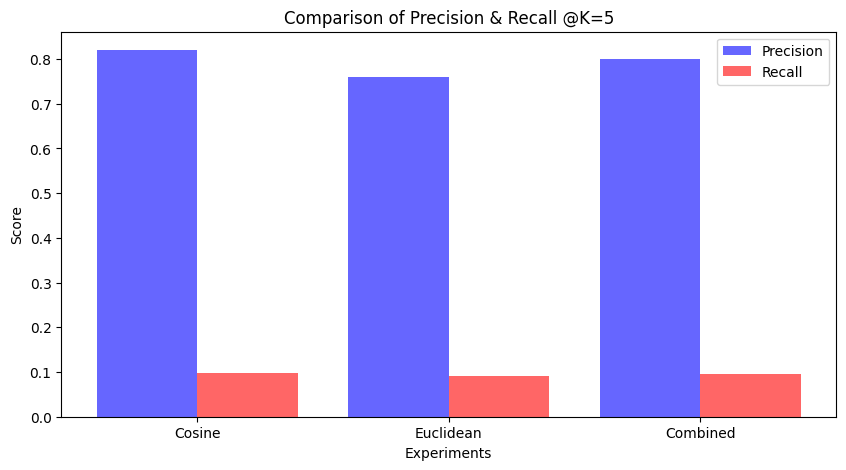

time: 197 ms (started: 2025-03-11 13:02:34 +00:00)


In [ ]:
experiments = ["Cosine", "Euclidean", "Combined"]
precision_scores = [mean_precision_1, mean_precision_2, mean_precision_3]
recall_scores = [mean_recall_1, mean_recall_2, mean_recall_3]

x = np.arange(len(experiments))

plt.figure(figsize=(10,5))
plt.bar(x - 0.2, precision_scores, width=0.4, label='Precision', color='blue', alpha=0.6)
plt.bar(x + 0.2, recall_scores, width=0.4, label='Recall', color='red', alpha=0.6)

plt.xticks(x, experiments)
plt.xlabel("Experiments")
plt.ylabel("Score")
plt.title(f"Comparison of Precision & Recall @K={k_value}")
plt.legend()
plt.show()

In [ ]:
from IPython.display import display

results_df = pd.DataFrame({
    "Experiment": ["Cosine", "Euclidean", "Combined"],
    "Precision@5": [mean_precision_1, mean_precision_2, mean_precision_3],
    "Recall@5": [mean_recall_1, mean_recall_2, mean_recall_3]
})

display(results_df)

,Experiment,Precision@5,Recall@5
0,Cosine,0.82,0.098651
1,Euclidean,0.76,0.091985
2,Combined,0.80,0.096429


time: 21.1 ms (started: 2025-03-11 13:03:32 +00:00)


#Test Environment

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/dataset/cropped_test/03542.jpg  
  inflating: /content/content/dataset/cropped_test/02082.jpg  
  inflating: /content/content/dataset/cropped_test/04744.jpg  
  inflating: /content/content/dataset/cropped_test/00458.jpg  
  inflating: /content/content/dataset/cropped_test/00212.jpg  
  inflating: /content/content/dataset/cropped_test/03773.jpg  
  inflating: /content/content/dataset/cropped_test/06915.jpg  
  inflating: /content/content/dataset/cropped_test/02386.jpg  
  inflating: /content/content/dataset/cropped_test/06649.jpg  
  inflating: /content/content/dataset/cropped_test/03975.jpg  
  inflating: /content/content/dataset/cropped_test/02698.jpg  
  inflating: /content/content/dataset/cropped_test/05147.jpg  
  inflating: /content/content/dataset/cropped_test/03244.jpg  
  inflating: /content/content/dataset/cropped_test/01785.jpg  
  inflating: /content/content/dataset/cropped_test/04808.jpg  
  in

Saving 00001.jpg to 00001.jpg


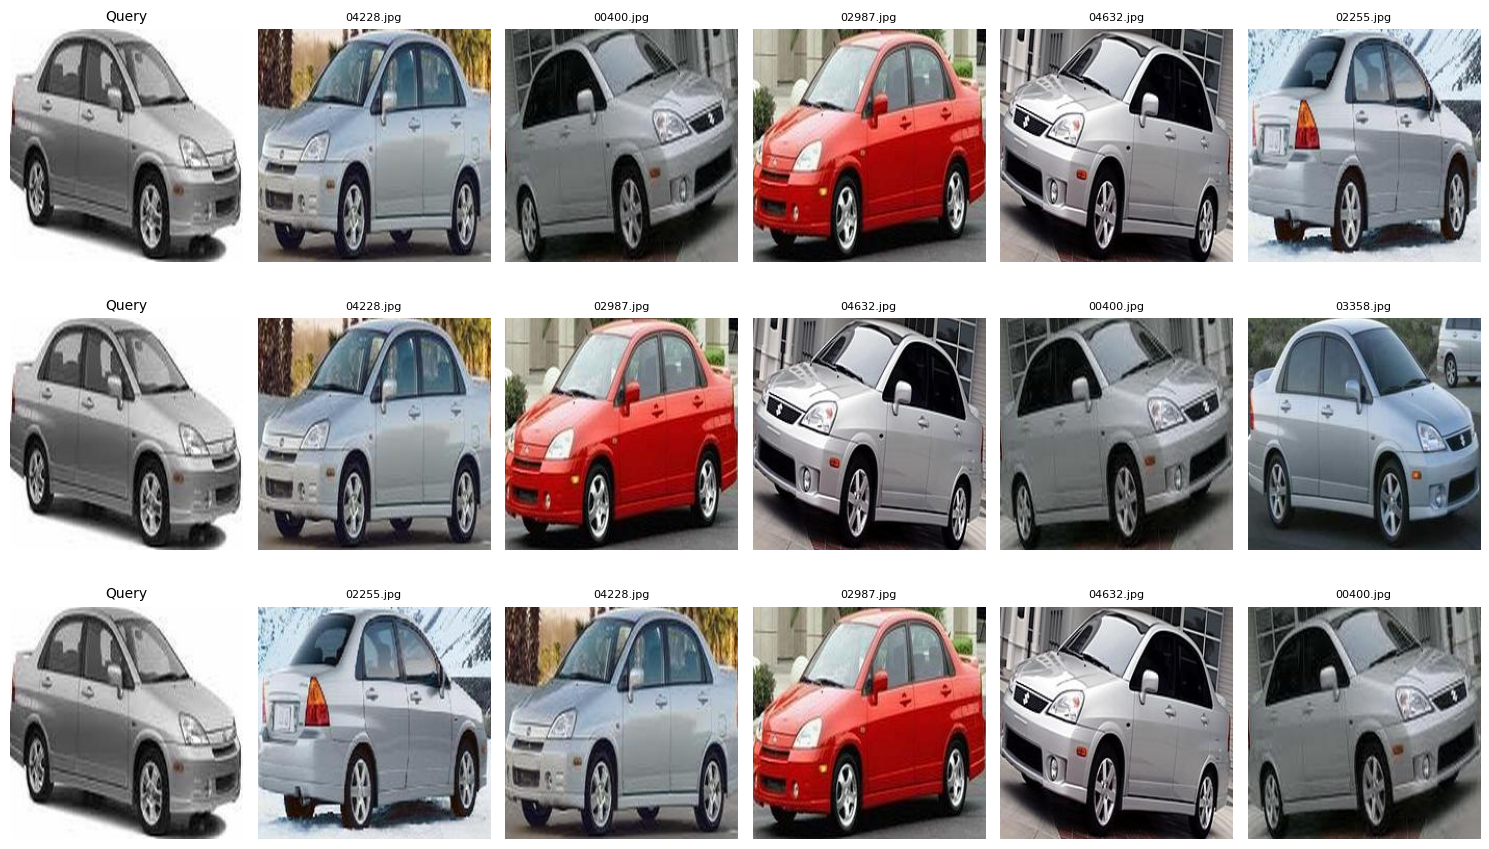

In [ ]:
import os
import gdown
import torch
import torch.nn as nn
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import shutil
from sklearn.neighbors import NearestNeighbors
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models

weights_url = "https://drive.google.com/uc?id=11UJGYz81SwS8q0cjIq2wM32z4HGf5CbY"
images_url = "https://drive.google.com/uc?id=1-0Ou_d-sWrn_30E-I75hf7hlcYyWKu_R"

if not os.path.exists("/content/experiment_2_weights.pth"):
    gdown.download(weights_url, "/content/experiment_2_weights.pth", quiet=False)

if not os.path.exists("/content/cropped_images.zip"):
    gdown.download(images_url, "/content/cropped_images.zip", quiet=False)

!unzip -o "/content/cropped_images.zip" -d "/content/"

def find_dataset_path():
    possible_dirs = ["/content/dataset", "/content/content/dataset"]
    for path in possible_dirs:
        if os.path.exists(os.path.join(path, "cropped_train")) and os.path.exists(os.path.join(path, "cropped_test")):
            return path
    return None

dataset_path = find_dataset_path()

if dataset_path is None:
    raise FileNotFoundError("Error")

train_images_path = os.path.join(dataset_path, "cropped_train")
test_images_path = os.path.join(dataset_path, "cropped_test")

if not os.path.exists(train_images_path) or not os.path.exists(test_images_path):
    raise FileNotFoundError(f"Error")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Experiment2(nn.Module):
    def __init__(self, num_classes=196, freeze_until=3):
        super(Experiment2, self).__init__()

        self.base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

        for idx, param in enumerate(self.base_model.features.parameters()):
            if idx < freeze_until:
                param.requires_grad = False

        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features, num_classes)
        )

        self.base_model.num_classes = num_classes

    def forward(self, x):
        return self.base_model(x)

best_model = Experiment2(num_classes=196).to(device)
best_model.load_state_dict(torch.load("/content/experiment_2_weights.pth", map_location=device))
best_model.eval()

def extract_embedding(model, image_path, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model.base_model.features(image)
        pooled = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
        embedding = pooled.view(pooled.size(0), -1)

    return embedding.cpu().numpy().flatten()

image_embeddings = {}
for image_path in os.listdir(train_images_path):
    full_path = os.path.join(train_images_path, image_path)
    embedding = extract_embedding(best_model, full_path, device)
    image_embeddings[full_path] = embedding

image_paths = list(image_embeddings.keys())
embeddings_matrix = np.array(list(image_embeddings.values()))

if embeddings_matrix.size == 0:
    raise ValueError("Error: No embeddings were generated. Check your dataset paths.")

knn_cosine = NearestNeighbors(n_neighbors=5, metric="cosine")
knn_cosine.fit(embeddings_matrix)

knn_euclidean = NearestNeighbors(n_neighbors=5, metric="euclidean")
knn_euclidean.fit(embeddings_matrix)

def find_similar_images(query_image_path, model, device):
    query_embedding = extract_embedding(model, query_image_path, device)
    distances, indices = knn_cosine.kneighbors([query_embedding])
    return [image_paths[idx] for idx in indices[0]]

def find_similar_images_euclidean(query_image_path, model, device):
    query_embedding = extract_embedding(model, query_image_path, device)
    distances, indices = knn_euclidean.kneighbors([query_embedding])
    return [image_paths[idx] for idx in indices[0]]

def find_weighted_similar_images(query_image_path, model, device, w_cosine=0.7, w_euclidean=0.3, k=5):
    query_embedding = extract_embedding(model, query_image_path, device)

    distances_cosine, indices_cosine = knn_cosine.kneighbors([query_embedding])
    distances_euclidean, indices_euclidean = knn_euclidean.kneighbors([query_embedding])

    combined_scores = {}

    for i in range(len(indices_cosine[0])):
        img_path = image_paths[indices_cosine[0][i]]
        combined_scores[img_path] = w_cosine * distances_cosine[0][i]

    for i in range(len(indices_euclidean[0])):
        img_path = image_paths[indices_euclidean[0][i]]
        if img_path in combined_scores:
            combined_scores[img_path] += w_euclidean * distances_euclidean[0][i]
        else:
            combined_scores[img_path] = w_euclidean * distances_euclidean[0][i]

    sorted_images = sorted(combined_scores.items(), key=lambda x: x[1])
    return [img[0] for img in sorted_images[:k]]

test_env_path = "/content/test_env"
os.makedirs(test_env_path, exist_ok=True)

def upload_test_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        image_path = os.path.join(test_env_path, filename)
        shutil.move(filename, image_path)
        return image_path
    return None

def test_image_retrieval(image_path, k=5):
    fig, axes = plt.subplots(3, k + 1, figsize=(15, 9))

    experiments = {
        "Cosine": find_similar_images(image_path, best_model, device),
        "Euclidean": find_similar_images_euclidean(image_path, best_model, device),
        "Combined": find_weighted_similar_images(image_path, best_model, device)
    }

    for row_idx, (experiment_name, similar_images) in enumerate(experiments.items()):
        axes[row_idx][0].imshow(Image.open(image_path))
        axes[row_idx][0].set_title("Query", fontsize=10)
        axes[row_idx][0].axis("off")

        for col_idx in range(k):
            if col_idx < len(similar_images):
                img_path = similar_images[col_idx]
                axes[row_idx][col_idx + 1].imshow(Image.open(img_path))
                axes[row_idx][col_idx + 1].set_title(os.path.basename(img_path), fontsize=8)
                axes[row_idx][col_idx + 1].axis("off")

        axes[row_idx][0].set_ylabel(experiment_name, fontsize=12, rotation=0, labelpad=30, ha='right', va='center')

    plt.tight_layout()
    plt.show()

query_image_path = upload_test_image()

if query_image_path:
    test_image_retrieval(query_image_path, k=5)